# Computer Vision Assignment 1 Part 2
---

Semester: **Fall 2023**

Due date: **October 5th 2023, 11.59PM EST.**

## Introduction
---
This assignment requires you to participate in a Kaggle competition with the rest of the class on the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb). The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the [private link](https://www.kaggle.com/t/f198351e92ff46d5a839fd73d22e9cbc).

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file `gtsrb_kaggle.csv` that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score.

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
---
You should make a copy of this Colab (`File->Save a copy in Drive`). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is NOT ALLOWED! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.

Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models.

## Important Details
---
• You are only allowed 8 submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 95%

• **Extra important:** Please use your NYU NetID as your team name on Kaggle, so the TAs can figure out which user you are on the leaderboard.

# Dataset Preparation
___

1.  Download [`dataset.zip`](https://cs.nyu.edu/~fergus/teaching/vision/dataset.zip) from the course website to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders: `training`, `validation`, and `testing`.
3.  Go to Google Drive (on your NYU account) and make a new directory (say `cv_kaggle_assignment`).
4.  Upload each of the three subfolders to it.
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested.


In [1]:
# Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
%cd  'cv_kaggle_assignment/'

/scratch/tl2546/DL_HW/cv_kaggle_assignment


/ext3/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Dataloader

In [2]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import numpy as np 
from collections import namedtuple

batch_size = 32
momentum = 0.9
lr = 0.01
epochs = 10
log_interval = 100


train_transforms = transforms.Compose([
                                    transforms.Resize((32, 32)),
                                    # transforms.ColorJitter(hue=.01, saturation=.01, contrast=.01),
                                    transforms.RandomRotation(10, interpolation=transforms.InterpolationMode.BILINEAR),
                                    transforms.GaussianBlur(3, sigma=(0.1, 0.5))
                                ])

def map_and_clamp_intensity(img, factor = 1, percentage = 0.01):
    C, H, W = img.shape
    reshaped_img = img.permute(1, 2, 0).view(-1, C)
    reshaped_img = factor * reshaped_img
    lower_percentile, upper_percentile = torch.quantile(reshaped_img, q = percentage, dim = 0), torch.quantile(reshaped_img, q = 1-percentage, dim = 0) 
    clamped_img = torch.clamp(reshaped_img, lower_percentile, upper_percentile)
    rescaled_img = (clamped_img - lower_percentile) /(upper_percentile - lower_percentile)

    transformed_img = rescaled_img.view(H, W, C).permute(2, 0, 1)
    return transformed_img
    
class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt", transform = train_transforms):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
        self.transform = transform

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        if self.transform:
            # self.X[idx] = self.transform(self.X[idx])
            self.X[idx] = map_and_clamp_intensity(img = self.X[idx], factor = 1.2)
            return self.X[idx], self.y[idx]
            
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt", transform = None)
aug_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt", transform = train_transforms)
aug_dataset = torch.utils.data.Subset(aug_dataset, indices= np.random.permutation(len(train_dataset))[:len(train_dataset)//5])

comb_dataset = torch.utils.data.ConcatDataset([train_dataset, aug_dataset])
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

comb_loader = torch.utils.data.DataLoader(
    comb_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)


In [3]:
img = train_dataset[0][0]

In [4]:
import matplotlib.pyplot as plt
import numpy as np 

num_classes = 43

def imshow(img):
  # img = img / 2 + 0.5     # unnormalize
  # npimg = img.numpy()
    img = torch.clamp(img, 0, 1)

    fig, ax = plt.subplots()
    ax.imshow(np.transpose(img, (1, 2, 0)), )
    ax.set_facecolor('white')  # Set the background color of the figure to white
    ax.axis('off')
    plt.show()

class_examples = {i: [] for i in range(num_classes)}

for img, label in aug_dataset:
    if len(class_examples[label.item()]) < 10:
        class_examples[label.item()].append(img)
    if all(len(class_examples[i]) == 10 for i in class_examples):
        break

/scratch/tl2546/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
for i in class_examples.keys():
    # print(f'Class: {i}')
    imshow(torchvision.utils.make_grid(class_examples[i],))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 100, kernel_size=4)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3,)
        self.bn2 = nn.BatchNorm2d(150)
        self.conv2_drop = nn.Dropout2d(0.2)
        self.conv2_skip = nn.Conv2d(100, 150, stride = 1, kernel_size = 1, )
        
        self.conv3 = nn.Conv2d(150, 250, kernel_size= 3,)
        self.bn3 = nn.BatchNorm2d(250)
        self.conv3_drop = nn.Dropout2d(0.2)
        self.conv3_skip = nn.Conv2d(150, 250, stride = 1, kernel_size = 1, )
        
        self.fc1 = nn.Linear(250*4, 200)
        self.fc2 = nn.Linear(200, nclasses, )

        self.layer_names = ['gelu_1', 'gelu_2','gelu_3', 'last_out']

    def forward(self, x):
        x = F.gelu(F.max_pool2d(F.gelu(self.bn1(self.conv1(x))), 2))
        gelu_1 = x
        x = F.gelu(F.max_pool2d(self.conv2_drop(F.gelu(self.bn2(self.conv2(x)))), 2))
        gelu_2 = x
        x = F.gelu(F.max_pool2d(self.conv3_drop(F.gelu(self.bn3(self.conv3(x)))), 2))
        gelu_3 = x
        
        x = x.view(-1, 250*4)
        x = F.gelu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        last_out = x
        
        outputs = namedtuple('outputs', self.layer_names)
        out = outputs(gelu_1, gelu_2, gelu_3, last_out)
        return F.log_softmax(x,dim=1), out


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=4)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
#         self.bn2 = nn.BatchNorm2d(128)
#         self.conv2_drop = nn.Dropout2d(0.2)
        
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
#         self.bn3 = nn.BatchNorm2d(256)
#         self.conv3_drop = nn.Dropout2d(0.2)
        
#         self.fc1 = nn.Linear(256*4, 200)
#         self.fc2 = nn.Linear(200, nclasses)

#     def forward(self, x):
#         x = F.gelu(F.max_pool2d(F.gelu(self.bn1(self.conv1(x))), 2))
#         x = F.gelu(F.max_pool2d(self.conv2_drop(F.gelu(self.bn2(self.conv2(x)))), 2))
#         x = F.gelu(F.max_pool2d(self.conv3_drop(F.gelu(self.bn3(self.conv3(x)))), 2))
        
#         x = x.view(-1, 256*4)
#         x = F.gelu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x,dim=1)

# Training

In [6]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience=3)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(aug_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output, _ = model(data)
        loss = F.nll_loss(output, target)
        # loss = ops.focal_loss.sigmoid_focal_loss(output, F.one_hot(target, num_classes = nclasses).to(torch.float64),reduction = 'sum')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(aug_loader.dataset),
                100. * batch_idx / len(aug_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output, _ = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        # validation_loss += ops.focal_loss.sigmoid_focal_loss(output, F.one_hot(target, num_classes = nclasses).to(torch.float64), reduction = "sum").item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    acc = correct/len(val_loader.dataset)
    return validation_loss, acc


# for epoch in range(1, epochs + 1):
#     train(epoch)
#     validation_loss, val_acc = validation()
#     lr_scheduler.step(validation_loss)
#     model_file = 'model_' + str(epoch) + '.pth'
#     torch.save(model.state_dict(), model_file)
#     print('\nSaved model to ' + model_file + '.')

In [7]:
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('mcdnn_acc_433_200_contrastonly_model_10.pth', map_location = device))
model.to(device)

validation_loss, val_acc = validation()


Validation set: Average loss: 0.1011, Accuracy: 3785/3870 (97.80%)



#### DeepDream

In [7]:
import math 

## from https://github.com/gordicaleksa/pytorch-deepdream/blob/master/The%20Annotated%20DeepDream.ipynb
class CascadeGaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing separately for each channel (depthwise convolution).

    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.

    """
    def __init__(self, kernel_size, sigma):
        super().__init__()

        if isinstance(kernel_size, int):
            kernel_size = [kernel_size, kernel_size]

        cascade_coefficients = [0.5, 1.0, 2.0]  # std multipliers, hardcoded to use 3 different Gaussian kernels
        sigmas = [[coeff * sigma, coeff * sigma] for coeff in cascade_coefficients]  # isotropic Gaussian

        self.pad = int(kernel_size[0] / 2)  # assure we have the same spatial resolution

        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernels = []
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for sigma in sigmas:
            kernel = torch.ones_like(meshgrids[0])
            for size_1d, std_1d, grid in zip(kernel_size, sigma, meshgrids):
                mean = (size_1d - 1) / 2
                kernel *= 1 / (std_1d * math.sqrt(2 * math.pi)) * torch.exp(-((grid - mean) / std_1d) ** 2 / 2)
            kernels.append(kernel)

        gaussian_kernels = []
        for kernel in kernels:
            # Normalize - make sure sum of values in gaussian kernel equals 1.
            kernel = kernel / torch.sum(kernel)
            # Reshape to depthwise convolutional weight
            kernel = kernel.view(1, 1, *kernel.shape)
            kernel = kernel.repeat(3, 1, 1, 1)
            kernel = kernel.to(device)

            gaussian_kernels.append(kernel)

        self.weight1 = gaussian_kernels[0]
        self.weight2 = gaussian_kernels[1]
        self.weight3 = gaussian_kernels[2]
        self.conv = F.conv2d

    def forward(self, input):
        input = F.pad(input, [self.pad, self.pad, self.pad, self.pad], mode='reflect')
        # Apply Gaussian kernels depthwise over the input (hence groups equals the number of input channels)
        # shape = (1, 3, H, W) -> (1, 3, H, W)
        num_in_channels = input.shape[1]
        grad1 = self.conv(input, weight=self.weight1, groups=num_in_channels)
        grad2 = self.conv(input, weight=self.weight2, groups=num_in_channels)
        grad3 = self.conv(input, weight=self.weight3, groups=num_in_channels)

        return (grad1 + grad2 + grad3) / 3

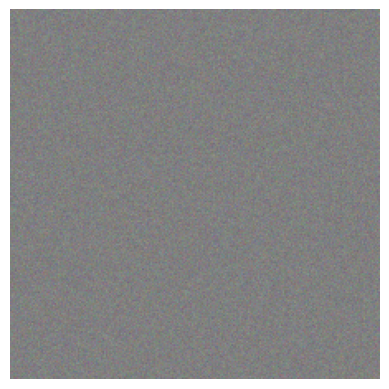

Using cache found in /home/tl2546/.cache/torch/hub/pytorch_vision_v0.10.0


In [8]:
iters = 256
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

LOWER_IMAGE_BOUND = torch.tensor((-IMAGENET_MEAN / IMAGENET_STD).reshape(-1, 1, 1)).to(device)
UPPER_IMAGE_BOUND = torch.tensor(((1 - IMAGENET_MEAN) / IMAGENET_STD).reshape(-1, 1, 1)).to(device)

def normalize_and_jitter(img, step=32):
    # You should use this as data augmentation and normalization,
    # convnets expect values to be mean 0 and std 1
    dx, dy = np.random.randint(-step, step - 1, 2)
    img_  = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)(
        img.roll(dx, -1).roll(dy, -2))
    # img_ = transforms.RandomRotation(10, interpolation=transforms.InterpolationMode.BILINEAR)(img_)
    img_ = transforms.GaussianBlur(3, (0.1, 0.5))(img_)
    return img_

image = torch.randn(3, 224, 224)
image = (image * 8 + 128) / 255 
image = image.to(device)

label = 281

imshow(image.cpu())


image.requires_grad_()
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', weights=torchvision.models.GoogLeNet_Weights.DEFAULT)
model.to(device)
model.eval()

loss = lambda tensor: tensor[0, label].mean()

for iteration in range(iters):   
    normalized_image = normalize_and_jitter(image)
    out = model(normalized_image.unsqueeze(0))
    
    # layer_ids_to_use = np.arange(len(outputs))

    loss_ = loss(out) 
    if image.grad is not None:
        image.grad.data.zero_()
    loss_.backward()

    grad = image.grad.data
    
    sigma = ((iteration + 1) / iters) * 2.0 + .5
    smooth_grad = grad
    # smooth_grad = CascadeGaussianSmoothing(kernel_size=9, sigma=sigma)(grad.unsqueeze(0))  
    # smooth_grad = transforms.GaussianBlur(3, sigma=(0.1, 0.5))(grad.unsqueeze(0))
    
    # # Normalize the gradients (make them have mean = 0 and std = 1)
    g_std = torch.std(smooth_grad)
    g_mean = torch.mean(smooth_grad)
    smooth_grad = (smooth_grad - g_mean)/g_std

    # Step 4: Update image using the calculated gradients (gradient ascent step)
    # image.data += config['lr'] * smooth_grad
    image.data += lr * smooth_grad.squeeze(0)

    # Step 5: Clear gradients and clamp the data (otherwise values would explode to +- "infinity")
    image.grad.data.zero_()
    image.data = transforms.GaussianBlur(3, (0.1, 0.5))(image.data)
    image.data = torch.clamp(image.data, 0, 1)


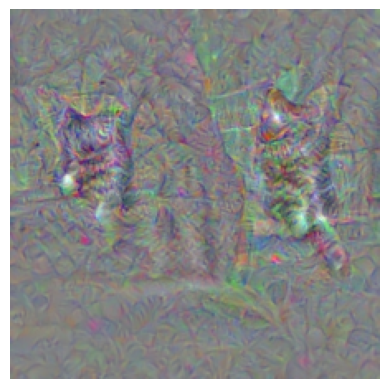

error: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:708: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'imwrite_'


In [14]:
import cv2 as cv 

def post_process_img(img):
    mean = IMAGENET_MEAN.reshape(-1, 1, 1)
    std = IMAGENET_STD.reshape(-1, 1, 1)
    img = (img * std) + mean  # de-normalize

    return img

def save_img(image, path):
    # Push to CPU, convert from (3, H, W) into (H, W, 3)
    image = image.permute(1, 2, 0)
    image = image.clamp(min=0, max=1)
    image = (image * 255).cpu().detach().numpy().astype(np.uint8)
    # opencv expects BGR (and not RGB) format
    cv.imwrite(path, image[:, :, ::-1])

# image_ = post_process_img(image.detach().cpu())
# imshow(image_)
imshow(image.detach().cpu())
save_img(image, './img.')

In [11]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 43.7 MB/s eta 0:00:00:00:0100:01


# Evaluate and Submit to Kaggle



In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model.eval() # Don't forget to put your model on eval mode !

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)

    output = model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

# Submitting to Kaggle

Now download the CSV file `grtsrb_kaggle.csv` from your Google drive and then submit it to Kaggle to check the performance of your model.

**Extra important:** Please use your NYU NetID as your team name on Kaggle, or your submissions will not be evaluated.  
You can rename your team easily from the Team tab: https://www.kaggle.com/competitions/nyu-computer-vision-csci-ga2271-2022/team.